In [ ]:
# !pip install mne
# !pip install plotly

In [1]:
import mne
import numpy as np
import json
# %matplotlib inline

## Importing EEG Data

In [144]:
raw_data_dir = './data/csv/'
file_name = 'Aof-t21 (1024Hz)'
n_col = 20 # The number of columns
raw_data = []
with open(raw_data_dir + file_name + '.csv', 'r') as fin:
    line = fin.readline() # Skip CSV header
    while True:
        line = fin.readline()
        if len(line) == 0:
            break # EOF
        line = line.split(',')
        raw_data.append([])
        for i in range(0, n_col):
            raw_data[-1].append(float(line[i]))
np_raw_data = np.array(raw_data)

In [145]:
# Event data
event_data_dir = './data/label/sync/1/'
onset_event_data = []

with open(event_data_dir + file_name + '.json', 'r') as fin:
    event_data = json.load(fin)
    np_event_data = np.array(event_data)
    
    onset_event_data = onset_event_data + ([0] * np_event_data[0][1]['start'])
    for i in range(0, len(np_event_data)):
        onset_event_data = onset_event_data + ([1] * (np_event_data[i][1]['end'] - np_event_data[i][1]['start'] + 1))
        next_start = len(np_raw_data)
        if i < len(np_event_data) - 1:
            next_start = np_event_data[i + 1][1]['start']
        onset_event_data = onset_event_data + ([0] * (next_start - np_event_data[i][1]['end'] - 1))
np_onset_event_data = np.array([onset_event_data])

In [146]:
# concatenate data with event
np_raw_arr_data = np.concatenate((np_raw_data.T, np_onset_event_data))

In [147]:
# Initialize an info structure
n_channel = 19
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
ch_types = ['eeg'] * n_channel + ['emg'] + ['stim']
sfreq = 1024 # Sampling rate 1024 Hz
montage = mne.channels.read_montage('standard_1005', ch_names)
mne_info = mne.create_info(
    ch_names = ch_names + ['24', 'onset'],
    sfreq = sfreq,
    ch_types = ch_types,
    montage = montage
)

mne_raw_data = mne.io.RawArray(np_raw_arr_data, mne_info)
print(mne_raw_data)

Creating RawArray with float64 data, n_channels=21, n_times=210944
    Range : 0 ... 210943 =      0.000 ...   205.999 secs
Ready.
<RawArray  |  None, n_channels x n_times : 21 x 210944 (206.0 sec), ~33.9 MB, data loaded>


In [148]:
events = mne.find_events(mne_raw_data, stim_channel='onset')
picks = mne.pick_types(mne_raw_data.info, eeg = True)
epochs = mne.Epochs(mne_raw_data, events, {'onset' : 1}, 0, 0.6, proj = False,
                        picks = picks, baseline = None, preload = True)
# epochs_offset = mne.Epochs(mne_raw_data, events, {'offset' : 1}, 1, 1.6, proj = False,
#                         picks = picks, baseline = None, preload = True)

# Workaround to be able to concatenate epochs
# epochs_offset.times = epochs.times
# epochs.append(epochs_offset)

30 events found
Events id: [1]
30 matching events found
Loading data for 30 events and 615 original time points ...
0 bad epochs dropped


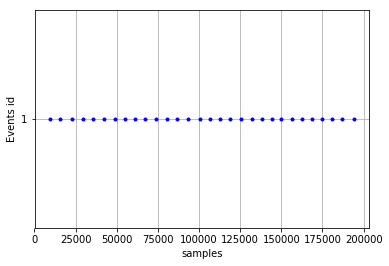

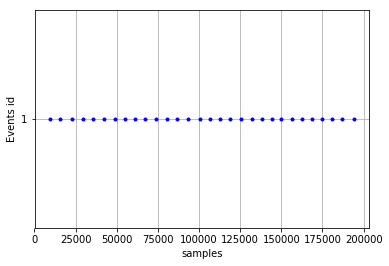

In [149]:
mne.viz.plot_events(events)

30 matching events found
0 projection items activated
0 bad epochs dropped


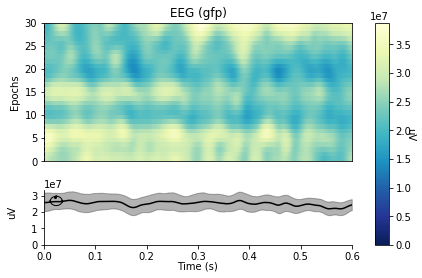

In [150]:
epochs.plot_image(combine='gfp', group_by='type', sigma=2., cmap="YlGnBu_r")

In [151]:
# epochs.plot_topo_image(vmin=-250, vmax=250, title='ERP images', sigma=2.)

In [152]:
evoked = epochs.average()

In [153]:
evoked.data.shape

(19, 615)

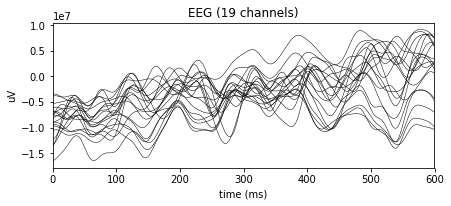

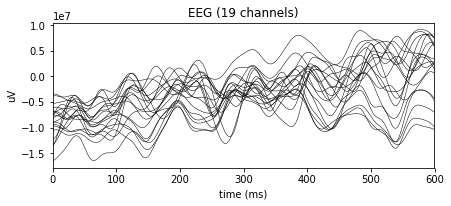

In [154]:
evoked.plot()

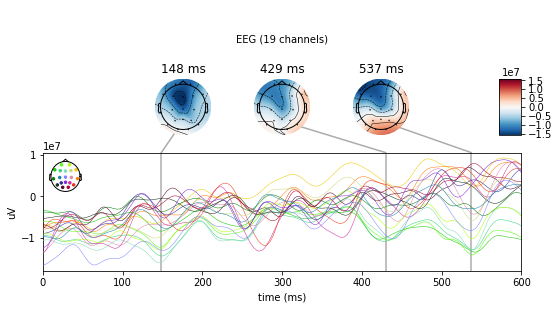

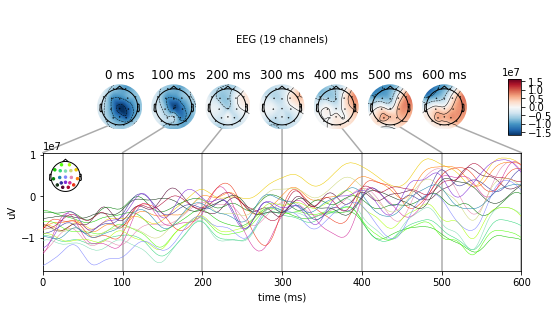

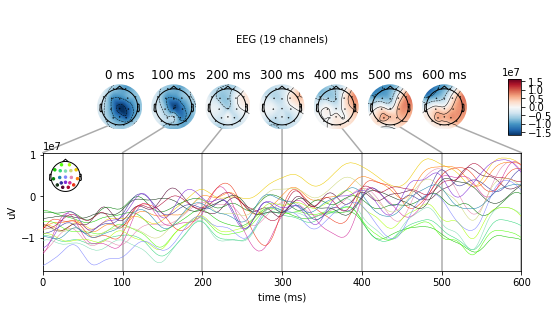

In [155]:
# Event-related Potential (ERP)
evoked.plot_joint()
evoked.plot_joint(times = np.arange(0, 0.61, 0.1))

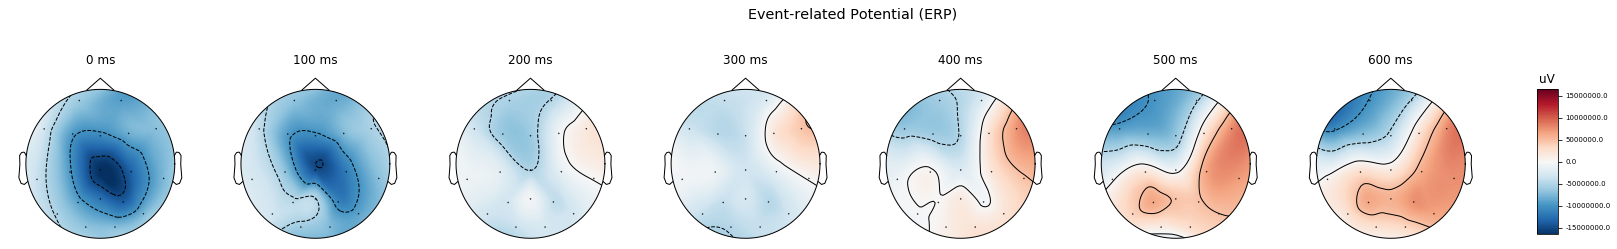

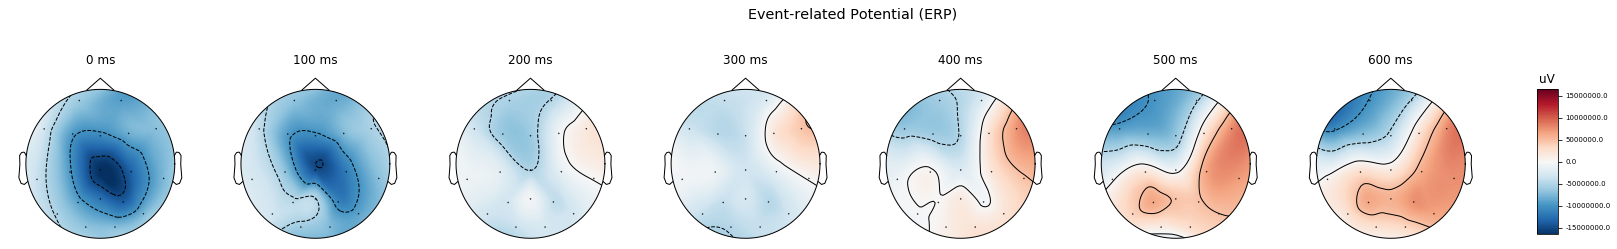

In [156]:
# Event-related Potential (ERP)
# %matplotlib notebook
# %matplotlib inline
title = 'Event-related Potential (ERP)'
# evoked.plot(titles = dict(eeg = title))
evoked.plot_topomap(times = np.arange(0, 0.61, 0.1), size = 2., title = title)

In [157]:
n_cycles = 2  # Number of cycles in Morlet wavelet
freqs = np.arange(30, 71, 1)  # Frequencies of interest

No baseline correction applied


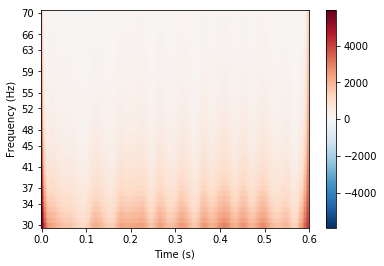

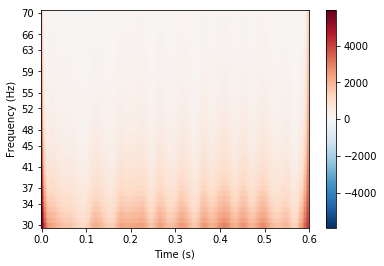

In [158]:
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs = freqs, n_cycles = n_cycles,
                                            return_itc = True, decim = 3, n_jobs = 1)
power.plot([power.ch_names.index('Pz')])

# EEG Electrode Positions

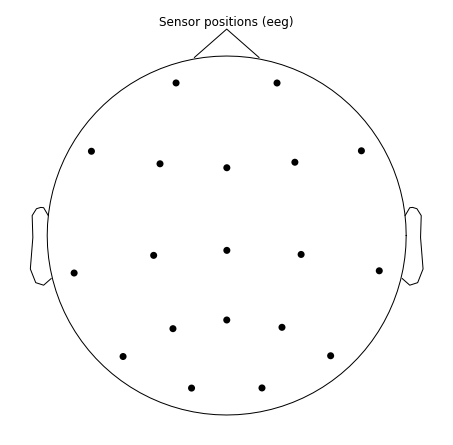

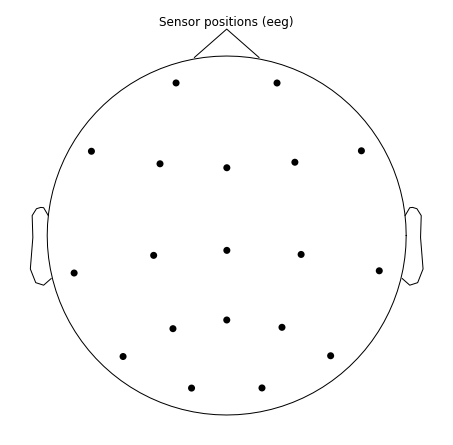

In [44]:
mne_raw_data.plot_sensors()

In [ ]:
def create_mne_epoch_from_label(fname, info):
    """Create a mne epoch instance from csv file"""
    # Add some more information
    info['description'] = 'dataset from ' + fname
    
    # Trials were cut from -1.5 to 1.5 seconds
    tmin = -1.5

    # Read EEG file
    data = pd.read_csv(fname, header=None)
    
    #and convert it to numpy array:
    npdata = np.array(data)
    
    #the first 4 columns of the data frame are the
    #subject number... subNumber = npdata[:,0]
    #trial number... trialNumber = npdata[:,1]
    #condition number... conditions = npdata[:,2]
    #and sample number (within a trial)... sampleNumber = npdata[:,3]
    
    #sample 1537 is time 0, use that for the event 
    onsets = np.array(np.where(npdata[:,3]==1537))
    conditions = npdata[npdata[:,3]==1537,2]

    #use these to make an events array for mne (middle column are zeros):
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))
    
    #now we just need EEGdata in a 3D shape (n_epochs, n_channels, n_samples)
    EEGdata = npdata.reshape(len(conditions),3072,74)
    #remove the first 4 columns (non-eeg, described above):
    EEGdata = EEGdata[:,:,4:]
    EEGdata = np.swapaxes(EEGdata,1,2)
    
    #create labels for the conditions, 1, 2, and 3:
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    
    # create raw object 
    custom_epochs = EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
    return custom_epochs

In [13]:
from plotly import tools
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font
# import matplotlib.pyplot as plt
import plotly.plotly as py

tools.set_credentials_file(username='pirsquareff', api_key='uJQEPfyUjaMvVnzhS83s')

# picks = mne.pick_types(mne_raw_data.info, meg='eeg', exclude=[])
# start, stop = mne_raw_data.time_as_index([0, 10])

data, times = mne_raw_data[:, 0:4000]
ch_names = mne_raw_data.info['ch_names']

In [20]:
mne_raw_data[:, 0:4000].plot(butterfly=True, group_by='position')

AttributeError: 'tuple' object has no attribute 'plot'

In [19]:
step = 1. / n_channel
kwargs = dict(domain=[1 - step, 1], showticklabels=False, zeroline=False, showgrid=False)

# create objects for layout and traces
layout = Layout(yaxis=YAxis(kwargs), showlegend=False)
traces = [Scatter(x=times, y=data.T[:, 0])]

# loop over the channels
for ii in range(1, n_channel):
        kwargs.update(domain=[1 - (ii + 1) * step, 1 - ii * step])
        layout.update({'yaxis%d' % (ii + 1): YAxis(kwargs), 'showlegend': False})
        traces.append(Scatter(x=times, y=data.T[:, ii], yaxis='y%d' % (ii + 1)))

# add channel names using Annotations
annotations = Annotations([Annotation(x=-0.06, y=0, xref='paper', yref='y%d' % (ii + 1),
                                      text=ch_name, font=Font(size=9), showarrow=False)
                          for ii, ch_name in enumerate(ch_names)])
layout.update(annotations=annotations)

# set the size of the figure and plot it
layout.update(autosize=False, width=1000, height=600)
fig = Figure(data=Data(traces), layout=layout)
py.iplot(fig, filename='shared xaxis')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pirsquareff/0 or inside your plot.ly account where it is named 'shared xaxis'


/opt/conda/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [ ]:


ch = 1 # particualr channel to study 
eeg = array(eeg)
y = eeg[:,ch]         # the signal, study channel 'ch'
L = len(y)            # signal length
fs = 500.0              # sampling rate
T = 1/fs                # sample time
t= linspace(1,L,L)*T   # time vector

f = fs*linspace(0,L/10,L/10)/L  # single side frequency vector, real frequency up to fs/2
Y = fft(y)

figure()
filtered = []
b= [] # store filter coefficient
cutoff = [0.5,4.0,7.0,12.0,30.0]

for band in xrange(0, len(cutoff)-1):
 wl = 2*cutoff[band]/fs*pi
 wh = 2*cutoff[band+1]/fs*pi
 M = 512      # Set number of weights as 128
 bn = zeros(M)
 
 for i in xrange(0,M):     # Generate bandpass weighting function
  n = i-  M/2       # Make symmetrical
  if n == 0:
   bn[i] = wh/pi - wl/pi;
  else:
   bn[i] = (sin(wh*n))/(pi*n) - (sin(wl*n))/(pi*n)   # Filter impulse response
 
 bn = bn*kaiser(M,5.2)  # apply Kaiser window, alpha= 5.2
 b.append(bn)
 
 [w,h]=freqz(bn,1)
 filtered.append(convolve(bn, y)) # filter the signal by convolving the signal with filter coefficients

figure(figsize=[16, 10])
subplot(2, 1, 1)
plot(y)
for i in xrange(0, len(filtered)):
  y_p = filtered[i]
  plot(y_p[ M/2:L+M/2])
axis('tight')
title('Time domain')
xlabel('Time (seconds)')

subplot(2, 1, 2)
plot(f,2*abs(Y[0:L/10]))
for i in xrange(0, len(filtered)):
  Y = filtered[i]
  Y = fft(Y [ M/2:L+M/2])
  plot(f,abs(Y[0:L/10]))
axis('tight')
legend(['original','delta band, 0-4 Hz','theta band, 4-7 Hz','alpha band, 7-12 Hz','beta band, 12-30 Hz'])

for i in xrange(0, len(filtered)):   # plot filter's frequency response
  H = abs(fft(b[i], L))
  H = H*1.2*(max(Y)/max(H))
  plot(f, 3*H[0:L/10], 'k')    
axis('tight')
title('Frequency domain')
xlabel('Frequency (Hz)')
subplots_adjust(left=0.04, bottom=0.04, right=0.99, top=0.97)
savefig('filtered.png')